In [1]:
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
# Check GPU available
#tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2925080265865155761,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11852734195716212383
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3620208947422139457
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11235482010
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15262056676091425152
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
submission=pd.read_csv('./sample_submission.csv')
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

# train.head()
# test.head()
# submission.head()

# Load training set
train_img=[]
train_label=[]
path='./images'
for im in tqdm(train['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=img.astype('float32')
    train_img.append(img)

# Load test set
test_img=[]
path='./images'
for im in tqdm(test['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=img.astype(('float32'))
    test_img.append(img)

100%|██████████| 1821/1821 [01:19<00:00, 22.81it/s]


In [4]:
# Create training labels
train_label=train.loc[:,'healthy':'scab']
train_img=np.array(train_img)
test_img=np.array(test_img)
train_label=np.array(train_label)

print(train_label)

print("Training set size:",train_img.shape)
print("Training label size:",train_label.shape)

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Training set size: (1821, 224, 224, 3)
Training label size: (1821, 4)


In [5]:
# Image pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_aug = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=False)  


516
592
622
91


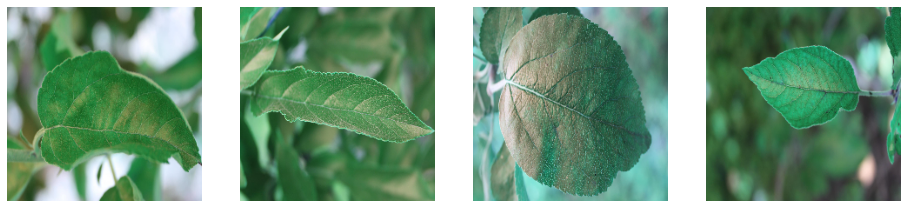

In [6]:
# Print sample images for each class
from numpy import expand_dims
from PIL import Image

healthy_list = [];
scab_list = [];
rust_list = [];
multiple_list = [];
for row in range(len(train_label)):
    if(train_label[row,0]==1):
        healthy_list.append(row)
    elif(train_label[row,1]==1):
        multiple_list.append(row)
    elif(train_label[row,2]==1):
        rust_list.append(row)
    elif(train_label[row,3]==1):
        scab_list.append(row)
print(len(healthy_list))
print(len(scab_list))
print(len(rust_list))
print(len(multiple_list))
len(healthy_list)+len(scab_list)+len(rust_list)+len(multiple_list)
fig, axes = plt.subplots(nrows=1, ncols=4)
for i in range(4):
    plt.subplot(1,4,i+1)
    img_idx = healthy_list[i]#healthy_list scab_list rust_list multiple_list
    img = train_img[img_idx,:,:,:]
    img = expand_dims(img, axis=0)
    img = img
    img = Image.fromarray(img[0,:,:,:].astype('uint8')).convert('RGB')
    plt.axis('off')
    plt.imshow(img)
fig.set_figheight(16)
fig.set_figwidth(16)

In [7]:
# Train-val split 80-20 split. No K-fold at the moment
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_img, train_label, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1456, 224, 224, 3)
(365, 224, 224, 3)
(1456, 4)
(365, 4)


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [23]:
# VGG16-based model + Dense(256) + Dense(4)
tf.keras.backend.clear_session()
import tensorflow.keras as keras
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')
model=Sequential()
model.add(base_model)
model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax'))
base_model.trainable=True
model.compile( optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 14,847,044
Trainable params: 14,847,044
Non-trainable params: 0
_________________________________________________________________


In [24]:
BS = 16
EPOCHS = 30;
history_aug= model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
	validation_data=(X_val, y_val), 
	epochs=EPOCHS)

# import tensorflow.keras as keras
# base_model.trainable=True
# model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
# BS = 16
# EPOCHS = 70;
# history_aug_secondpart = model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
# 	validation_data=(X_val, y_val), 
# 	epochs=EPOCHS)

  ...
    to  
  ['...']
Train for 91 steps, validate on 365 samples
Epoch 1/30
91/91 [==============================] - 45s 495ms/step - loss: 1.0047 - accuracy: 0.6202 - val_loss: 0.5228 - val_accuracy: 0.8466
Epoch 2/30
91/91 [==============================] - 44s 482ms/step - loss: 0.4327 - accuracy: 0.8626 - val_loss: 0.3062 - val_accuracy: 0.8904
Epoch 3/30
91/91 [==============================] - 44s 483ms/step - loss: 0.2953 - accuracy: 0.9066 - val_loss: 0.3276 - val_accuracy: 0.8877
Epoch 4/30
91/91 [==============================] - 44s 483ms/step - loss: 0.2378 - accuracy: 0.9210 - val_loss: 0.2855 - val_accuracy: 0.9260
Epoch 5/30
91/91 [==============================] - 44s 482ms/step - loss: 0.1810 - accuracy: 0.9409 - val_loss: 0.3090 - val_accuracy: 0.9151
Epoch 6/30
91/91 [==============================] - 44s 483ms/step - loss: 0.1510 - accuracy: 0.9526 - val_loss: 0.2657 - val_accuracy: 0.9205
Epoch 7/30
91/91 [==============================] - 44s 483ms/step - loss

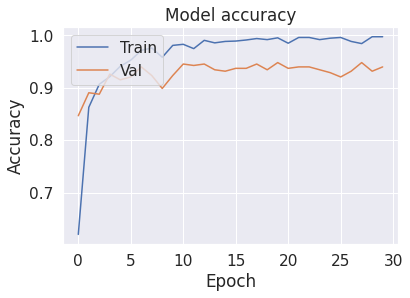

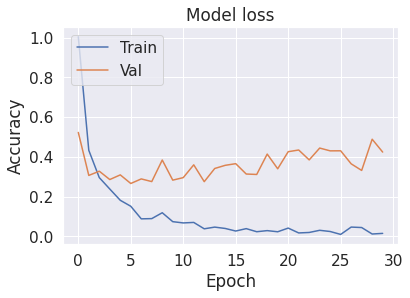

In [25]:
# Plot training loss and accuracy
history = history_aug
plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('./results/VGG_onestep_accuracy.png', dpi=150)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.savefig('./results/VGG_onestep_loss.png', dpi=150)



In [ ]:
# img_idx = 9;
# img = train_img[img_idx,:,:,:]
# featVisualization(visualize_model, img)

In [ ]:
# Save training results
f = open("./results/VGG_history_aug_onestep.pkl","wb")
pickle.dump(history.history,f)
f.close()

In [ ]:
#  Load old training results
# new_history = pickle.load( open( "./results/VGG_history.pkl", "rb" ) )


In [26]:
# submission
y_pred = model.predict(test_img)


submission.loc[:,'healthy':'scab'] = y_pred
submission.to_csv('submission_VGG_onestep.csv',index = False)

# PLot confusion matrix

val_pred = model.predict(X_val)

pred_index = np.argmax(val_pred,1)
y_val_index = np.argmax(y_val,1)
type(pred_index)

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_val_index, pred_index)

array([[ 97,   0,   2,   0],
       [  2,   5,   3,   9],
       [  0,   0, 120,   0],
       [  5,   0,   1, 121]])

In [38]:
y_val_index[364]

2

2
3
9
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3


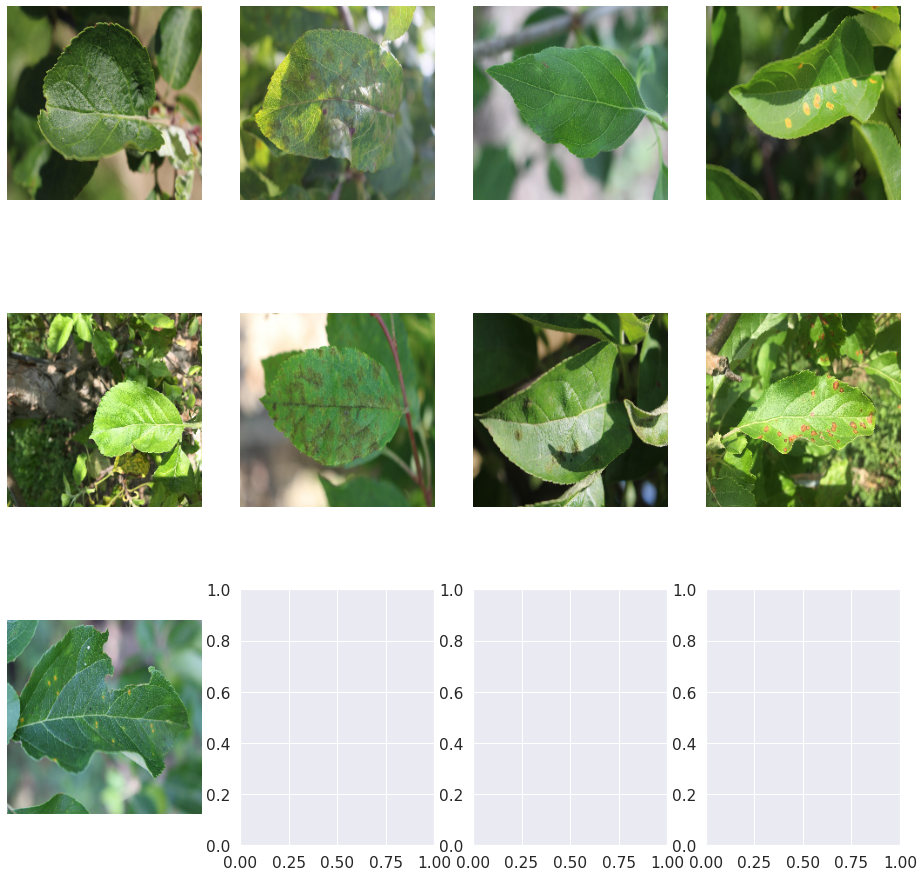

In [69]:
# Plot wrong 
val_healthy_list = [];
val_scab_list = [];
val_rust_list = [];
val_multiple_list = [];
multiple_healthy = [];
multiple_rust = [];
multiple_scab= []

for i in range(len(y_val_index)):
    if(y_val_index[i]==0):
        val_healthy_list.append(i)
    elif(y_val_index[i]==1):
        val_multiple_list.append(i)
        if pred_index[i]==0:
            multiple_healthy.append(i);
        if pred_index[i]==2:
            multiple_rust.append(i); 
        if pred_index[i]==3:
            multiple_scab.append(i); 
    elif(y_val_index[i]==2):
        val_rust_list.append(i)
    elif(y_val_index[i]==3):
        val_scab_list.append(i)
#
print(len(multiple_healthy))
print(len(multiple_rust))
print(len(multiple_scab))
fig, axes = plt.subplots(nrows=3, ncols=4)
for i in range(len(multiple_scab)):
    plt.subplot(3,4,i+1)
    img_idx = multiple_scab[i]#Print wrongly classified multiple diseases
    img = train_img[1456+img_idx,:,:,:]
    img = img[:,:,::-1]
    print(y_val_index[img_idx])
    print(pred_index[img_idx])
    img = expand_dims(img, axis=0)
    img = Image.fromarray(img[0,:,:,:].astype('uint8')).convert('RGB')
    plt.axis('off')
    plt.imshow(img)
    
fig.set_figheight(16)
fig.set_figwidth(16)
    

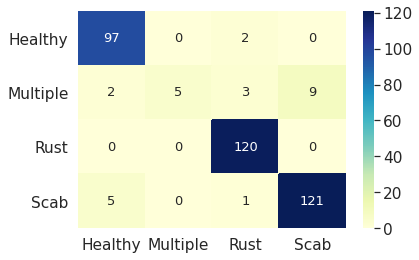

In [27]:
# VGG 30/70
confusion_VGG_two_step = np.array([[ 90,   2,   2,   5],
       [  1,  12,   2,   4],
       [  1,   0, 119,   0],
       [  4,   2,   1, 120]])
# VGG one step 30 epochs
confusion_VGG_one_step_30 = np.array([[ 97,   0,   2,   0],
       [  2,   5,   3,   9],
       [  0,   0, 120,   0],
       [  5,   0,   1, 121]])
# Google 30/70
confusion_Google_two_step = np.array([[ 96,   1,   0,   2],
       [  2,   8,   3,   6],
       [  1,   1, 116,   2],
       [  7,   3,   0, 117]])
# Google 100
confusion_Google_one_step = np.array([[ 98,   0,   0,   1],
       [  3,  11,   1,   4],
       [  0,   2, 117,   1],
       [  4,   1,   0, 122]])
# ResNet 30/70
confusion_ResNet_two_step  = np.array([[ 97,   0,   1,   1],
       [  3,   9,   4,   3],
       [  2,   0, 118,   0],
       [  5,   2,   2, 118]])


# Plotting
confusion = confusion_VGG_one_step_30
import seaborn as sn
df_cm = pd.DataFrame(confusion, index=["Healthy", "Multiple", "Rust", "Scab"], columns=["Healthy", "Multiple", "Rust", "Scab"])
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d", annot_kws={"size": 13})

In [98]:
# SVM output save to CSV
from sklearn.preprocessing import OneHotEncoder
output = np.array([0, 2, 3, 1, 0, 0, 2]) # change to actual output
enc = OneHotEncoder()
enc.fit(output.reshape(-1,1))
output_onehot = enc.transform(output.reshape(-1,1)).toarray()
output_onehot
submission.shape

submission.loc[:,'healthy':'scab'] = output_onehot
submission.to_csv('submission_SVM.csv',index = False)

(1821, 5)